In [1]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color
import os 
import cv2
import PIL, PIL.Image
import tensorflow as tf
from tensorflow import keras
import pathlib
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications import inception_v3
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, UpSampling2D, Reshape,GlobalAveragePooling2D
from keras import backend as K
import numpy as np
import matplotlib.image as mpimg
import os
import random
from icrawler.builtin import GoogleImageCrawler
from keras.layers import Input, Concatenate, Dense
from PIL import Image
from keras.callbacks import LambdaCallback
import keras.backend as K
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model


In [2]:
path = 'C:/TaiLieuHocTap/RMIT/A_2023/ML_A23/GroupTest/Test/hoalacanhTest/data/Raw'
cleaned_path=  'C:/TaiLieuHocTap/RMIT/A_2023/ML_A23/GroupTest/Test/hoalacanhTest/cleaned_data'

### EDA - data exploratory and cleaning

In [3]:
Flowers = tf.keras.preprocessing.image_dataset_from_directory(path)

Found 16362 files belonging to 8 classes.


In [4]:
new_name = 'image'
index = 1

for root, dirs, files in os.walk(path):
    for filename in files:
        if filename.endswith('.jpeg') or filename.endswith('.jpg'):
            path = os.path.join(root, filename)
            new_filename = f'{new_name}_{index}.PNG'
            new_file_path = os.path.join(root, new_filename)
            os.rename(path, new_file_path)
            index += 1


In [5]:
#showing information
class_names = Flowers.class_names
print(class_names)

['Baby', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


In [6]:
for i in class_names:
    print((i),len(os.listdir(path + '/' + i)))

Baby 2062
Calimerio 2025
Chrysanthemum 2064
Hydrangeas 2048
Lisianthus 2090
Pingpong 2022
Rosy 2002
Tana 2049


In [10]:
#convert to numpy array
iterator = Flowers.as_numpy_iterator()
batch = next(iterator)
print(batch[0].shape)
print(batch[1].shape)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext]

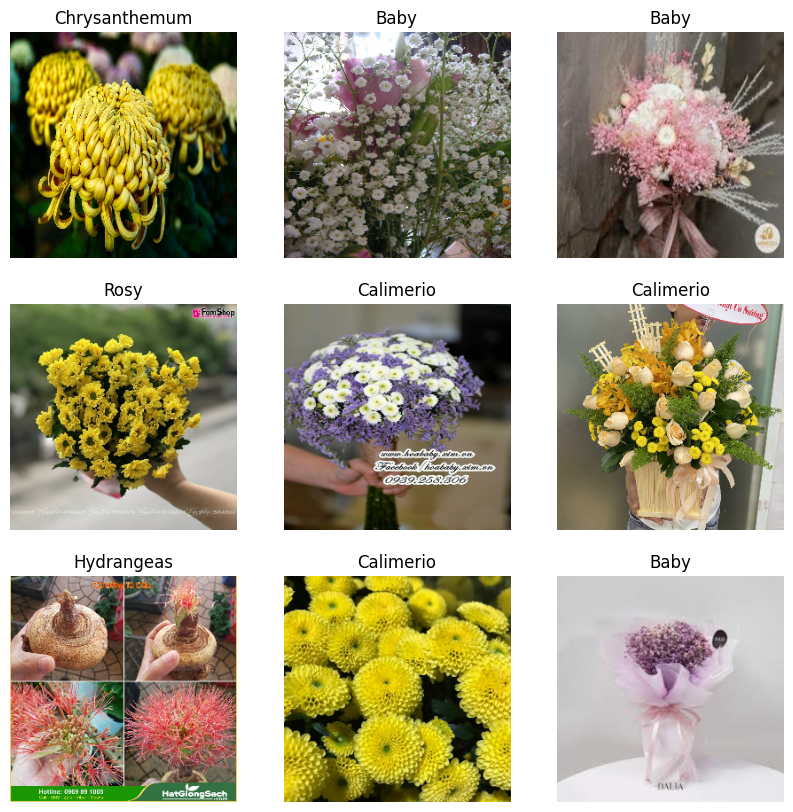

In [ ]:
#plot the images and the name of the class 
plt.figure(figsize=(10,10))
for images, labels in Flowers.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
def remove_identical_images(folder, threshold=0.95):
    hashes = {}
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        with Image.open(filepath) as img:
            hash = imghash.average_hash(img)
        if hash in hashes:
            hashes[hash].append(filepath)
        else:
            hashes[hash] = [filepath]

    for identical_files in hashes.values():
        if len(identical_files) > 1:
            for file in identical_files[1:]:
                os.remove(file)


In [ ]:
#normalize images
def normalize_images(path, cleaned_path):
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            img = Image.open(path + '/' + filename)
            img = img.resize((180, 180))
            img = img.convert('RGB')
            img.save(cleaned_path + '/' + filename.split('.')[0] + '.jpg')
        else:
            continue
    
normalize_images(path, cleaned_path)


In [ ]:
#remove outliers
def remove_image_outliers(path, size_threshold=500000, aspect_ratio_threshold=1.5):
    for root, dirs, files in os.walk(path):
        for file_name in files:
            if file_name.endswith('.jpg') or file_name.endswith('.png') or file_name.endswith('.jpeg'):
                file_path = os.path.join(root, file_name)
                if os.path.getsize(file_path) > size_threshold:
                    os.remove(file_path)
                    continue
                img = Image.open(file_path)
                width, height = img.size
                aspect_ratio = width / height
                if aspect_ratio > aspect_ratio_threshold:
                    os.remove(file_path)
                    continue


In [ ]:
len(Flowers)

512

In [ ]:
#split into train and validation , test set
train_size = int (0.8 * len(Flowers))
val_size = int (0.1 * len(Flowers))
test_size = int (0.1 * len(Flowers))

train = Flowers.take(train_size)
val = Flowers.skip(train_size).take(val_size)
test = Flowers.skip(train_size + val_size).take(test_size)
print(len(train), len(test), len(val))



409 51 51


In [ ]:
#set up the parameters
batch_size = 128
img_height = 256
img_width = 256
num_classes = 8
hidden_layer_dim = 64
epochs = 16
learning_rate = 1e-3

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Dense(hidden_layer_dim),
    tf.keras.layers.Dense(hidden_layer_dim, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid'),
    tf.keras.layers.Dense(num_classes)
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 64)                12582976  
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 12,591,816
Trainable params: 12,591,816
Non-trainable params: 0
_________________________________________________________________


# optimmizer : 
- RMSprop: adapts the learning rate for each weight in the network based on (SGD) optimizer. (divide the learning rate) by a running average of the magnitudes for each weights 

In [ ]:
#optimize the model
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate= 1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 64)                12582976  
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 12,591,816
Trainable params: 12,591,816
Non-trainable params: 0
_________________________________________________________________


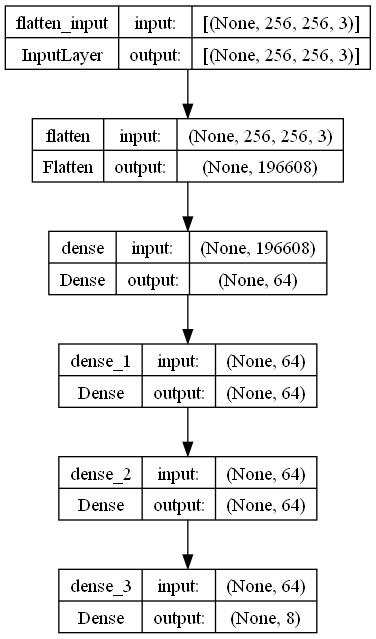

In [ ]:
#plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1)
hist  = model.fit(train, epochs=epochs, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/16
 19/409 [>.............................] - ETA: 45s - loss: 2.1646 - accuracy: 0.1069

InvalidArgumentError: Graph execution error:

Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_981]

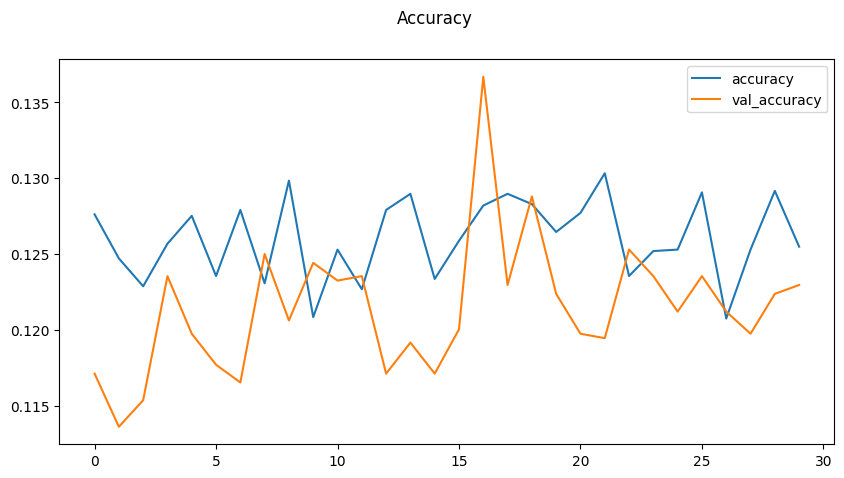

In [ ]:
#accuracy between val and train
fig = plt.figure(figsize=(10,5))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
fig.suptitle('Accuracy')
plt.legend()
plt.show()

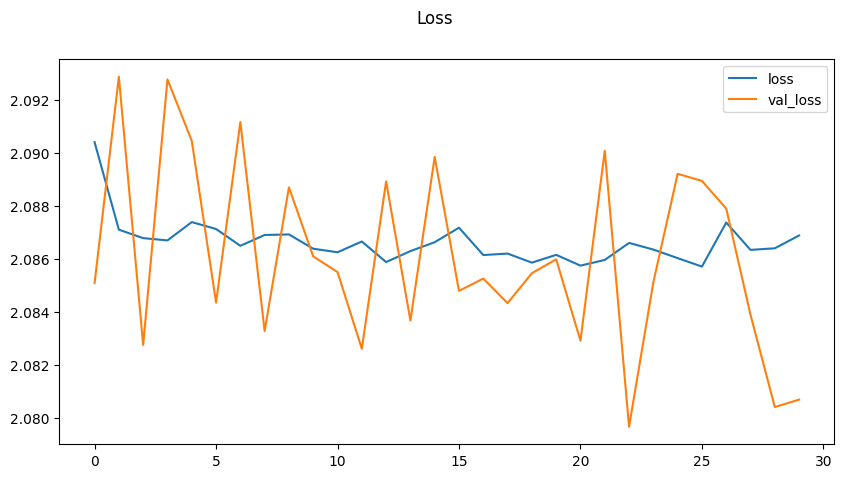

In [ ]:
#lost and val_loss
fig = plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
fig.suptitle('Loss')
plt.legend()
plt.show()



In [ ]:
#import module from tensorflow
from keras.metrics import BinaryAccuracy, Precision, Recall

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
from sklearn.metrics import classification_report
for batch in test.as_numpy_iterator():
    images, labels = batch
    yhat = model.predict(images)
    yhat = np.argmax(yhat, axis=1)
    
    pre.update_state(labels, yhat)
    re.update_state(labels, yhat)
    acc.update_state(labels, yhat)

1/1 [==============================] - 0s 39ms/step


In [ ]:
print('Precision: ', pre.result().numpy())
print('Recall: ', re.result().numpy())
print('Accuracy: ', acc.result().numpy())

Precision:  0.8668224
Recall:  1.0
Accuracy:  0.12587617


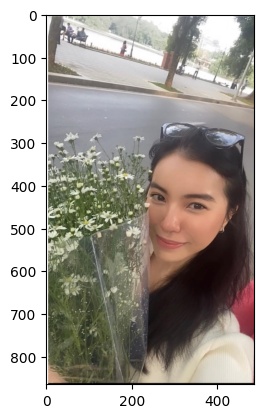

In [ ]:
#predict on test 
img = cv2.imread("C:\TaiLieuHocTap\RMIT\A_2023\ML_A23\GroupProjectAmike\hoalacanhUpdate\Rmit2023a-cosc2753-assignment2\PUlowers.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = cv2.resize(img, (256, 256))
resize = resize.astype(np.float32) / 256.0
resize = (resize - 0.5) * 2.0  # Rescale to [-1, 1]
resize = np.expand_dims(resize, axis=0)
resize.shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(resize)
yhat = np.argmax(yhat, axis=1)
print(yhat)

1/1 [==============================] - 0s 59ms/step
[7]


###  below are the testing code using another model and trying to implement algorithm to find optimals parameters

In [ ]:
#cross validate '
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

num_fold = 6
kf = KFold(n_splits=num_fold, shuffle=True)

for train_index, val_index in kf.split(Flowers):
    train = Flowers.take(train_index)
    val = Flowers.take(val_index)
    model.fit(train, epochs=epochs, validation_data=test, callbacks=[tensorboard_callback])
    yhat = model.predict(test)
    yhat = np.argmax(yhat, axis=1)
    print('Accuracy: ', accuracy_score(test, yhat))
    print('Precision: ', precision_score(test, yhat, average='weighted'))
    print('Recall: ', recall_score(test, yhat, average='weighted'))
    print('F1: ', f1_score(test, yhat, average='weighted'))
 

In [ ]:
#using grid search to find the best parameters
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

def grid_search(train, val, test):
    model = KerasClassifier(build_fn=model, verbose=0)
    param_grid = {'num_filters': [8, 16, 32], 
                  'kernel_size': [(3,3), (5,5)], 
                  'pool_size': [(2,2)], 
                  'num_hidden': [128, 256], 
                  'dropout_rate': [0.2, 0.5], 
                  'learning_rate': [0.001, 0.01, 0.1]}
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(train, val)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# impllement the class learningRate and the algorithm
class learningRate:
    def __init__(self, model):
        self.model = model
        self.lr = []
        self.loss = []
        self.batch_num = 1
        self.best_lost = 1.85
        self.best_lr = 0.001
    # batchEnd method to update the learning rate 
    def batchEnd(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.lr.append(lr)
        loss = logs['loss']
        self.loss.append(loss)
        self.batch_num += 1
        
        if loss < self.best_lost:
            self.best_lost = loss
            self.best_lr = lr

        if batch > 5 and (loss > 4 * self.best_lost or K.get_value(self.model.optimizer.lr) < 1e-6):
            self.model.stop_training = True
            return

        if loss< 0.5 * self.best_lost and lr < 0.1:
            K.set_value(self.model.optimizer.lr, lr * 2)
            self.batch_num = 0
            
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.95)
    
    #find the beset learning rate)
    def find (self, start_lr, end_lr, epochs=epochs, batch_size=batch_size): 
        batch_num = epochs * len(train) / batch_size
        self.best_lr = (end_lr / start_lr) ** (1 / batch_num)
        original_lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, start_lr)
        callback = LambdaCallback(on_batch_end = self.batchEnd)
        
        self.model.fit(train, epochs=epochs, batch_size=batch_size, callbacks=[callback])
        
        K.set_value(self.model.optimizer.lr, original_lr)
    

lr = learningRate(model)
lr_callback = LambdaCallback(on_batch_end = lr.batchEnd)



# build another model 
###
 using inception_v3: inceptionV3 is a convolutional module that performs different types of convolutions and pooling processes in parallel and then combines the results into a single output tensor. This lets the network learn a mix of features at different sizes and resolutions, which can help it recognise pictures better.

- include_top: Boolean, whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.
- weights: One of None (random initialization), imagenet (pre-training on ImageNet), or the path to the weights file to be loaded. Default to imagenet.
- input_tensor: Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model. input_tensor is useful for sharing inputs between multiple different networks. Default to None.
- input_shape: Optional shape tuple, only to be specified if include_top is False 
- pooling: Optional pooling mode for feature extraction when include_top is False.
None (default) means that the output of the model will be the 4D tensor output of the last convolutional block.
avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
max means that global max pooling will be applied.
- classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified. Default to 1000.
- classifier_activation: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".


In [ ]:
inception_v3 = tf.keras.applications.InceptionV3
model2  = inception_v3(weights='imagenet', include_top=False, input_shape=(256,256,3), classes = 8)
x = model2.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer and reshape it
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=10, activation='sigmoid')(x)
x = Reshape(target_shape=(256,256,3))(x)
model = Model(inputs=model2.input, outputs=x)

for layer in model.layers:
    if len(layer.get_weights()) > 0 and layer.trainable:
        layer.trainable = False
        
for layer in model2.layers:
    if 'conv2d' in layer.name:
        layer.trainable = False



In [ ]:
#visualize the model 
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#one hot encoding
train = train.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val = val.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
test = test.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [ ]:
#freeze the model where number of params = 0 
for layer in model2.layers:
    if len(layer.get_weights()) > 0 and layer.trainable:
        layer.trainable = True
    else:
        layer.trainable = False



In [ ]:
#print the input and output shape
print(model2.input_shape)
print(model2.output_shape)


(None, 256, 256, 3)
(None, 6, 6, 2048)


In [ ]:
#complie the model
model2.compile(optimizer=RMSprop(learning_rate= 1e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])


In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical

generator_inputs = Input(shape=(100,))
x = Dense(7*7*256)(generator_inputs)
x = Reshape((7, 7, 256))(x)
x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(x)
generator = Model(generator_inputs, x)


In [ ]:
# Define the discriminator architecture
discriminator_inputs = Input(shape=(28, 28, 1))
x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(discriminator_inputs)
x = Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(3, activation='sigmoid')(x)
discriminator = Model(discriminator_inputs, x)


cGAN_inputs = Input(shape=(100,))
image_class = Input(shape=(10,))
generated_images = generator(cGAN_inputs)
discriminator_output = discriminator(generated_images)
cGAN = Model([cGAN_inputs, image_class], discriminator_output)



In [ ]:
cGAN.compile(optimizer='adam', loss='binary_crossentropy')
cGAN.summary()
